In [1]:
import h5py
import numpy as np
stim='DM'

all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool']

#get the time dimension of each layer
all_layers_time_shape=[]
save_features_dir = f'../data/{stim}_clips_cochresnet50/'
file = h5py.File(f'{save_features_dir}cochresnet50_activations.h5', 'r')
for layer in all_layers:
    all_layers_time_shape.append(file[layer].shape[1])
all_layers_time_shape

[211, 6784, 3392, 13568, 13824, 14336, 14336, 2048]

In [2]:
save_features_dir = f'../data/{stim}_clips_cochresnet50/'
file = h5py.File(f'{save_features_dir}cochresnet50_activations_full.h5', 'r')
for layer in all_layers:
    print(layer)
    print(file[layer].shape)

input_after_preproc
(749, 82290)
conv1_relu1
(749, 1322880)
maxpool1
(749, 332416)
layer1
(749, 1329664)
layer2
(749, 677376)
layer3
(749, 358400)
layer4
(749, 186368)
avgpool
(749, 2048)


In [3]:
test=np.asanyarray(file['input_after_preproc'])
file.close()
test.shape

(749, 82290)

In [4]:
test2=np.reshape(test, (test.shape[0],211,-1))
test2.shape

(749, 211, 390)

In [5]:
import matplotlib.pyplot as plt

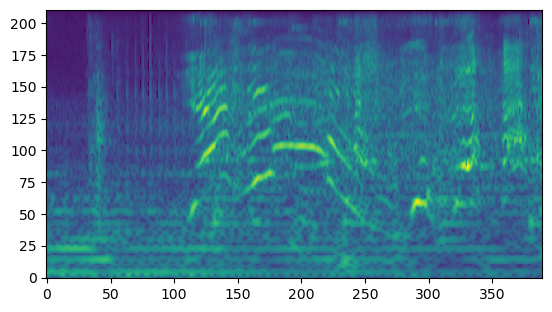

In [6]:
plt.imshow(test2[0,:,:],origin='lower')

In [12]:
test2.shape

(749, 211, 390)

For spectrogram:

for each of the 749 time points:
- there are 390 time points and 211 bins
- flatten the bins/third dimension and apply PCA across the flattened dimension
- Then average across time???

## plot 100 TRs and plots of the cochleagram and PCA features as gif

In [147]:
from sklearn.decomposition import PCA
n_components=20
transformer = PCA(n_components=n_components)
for ind in range(100):
    X=transformer.fit_transform(test2[ind,:,:].T)
    
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 7))  # Adjust the size as needed
    axs = axs.flatten()
    ax = axs[0]
    ax.imshow(test2[ind,:,:],origin='lower',interpolation='nearest',aspect='auto')
    ax.set_title(f'cochleagram input, {test2[ind,:,:].shape}')
    
    ax = axs[1]
    ax.imshow(X.T,origin='lower',interpolation='nearest',aspect='auto')
    ax.set_title(f'PCA(cochleagram input), {X.T.shape}')
    
    ax = axs[2]
    X2=test2[ind,:,:].T
    ax.imshow( np.expand_dims(np.mean(X2,axis=0), axis=0).T ,origin='lower',interpolation='nearest',aspect='auto')
    ax.set_title(f'mean(cochleagram input), {np.expand_dims(np.mean(X2,axis=0), axis=0).T.shape}')
    
    ax = axs[3]
    ax.imshow( np.expand_dims(np.mean(X,axis=0), axis=0).T ,origin='lower',interpolation='nearest',aspect='auto')
    ax.set_title(f'mean( PCA(cochleagram input), {np.expand_dims(np.mean(X,axis=0), axis=0).T.shape})')
    
    fig.suptitle(f'DM, TR {ind:03d}', fontsize=16)
    
    plt.tight_layout()
    fig.savefig(f'../plots/temp/gif_{ind:03d}.png')
    plt.close()



In [156]:
from PIL import Image, ImageDraw, ImageFont
import os
import numpy as np
features=['gif']
for feature in features:
    filelist=[]
    import os
    for root, dirs, files in os.walk(f'../plots/temp/'):
        for name in files:
            filelist.append(os.path.join(root, name))

    append_images=[]
    for i,f in enumerate(filelist):
        if i==0:
            img1 = Image.open(f)
        else:
            img2 = Image.open(f)
            append_images.append(img2)
    img1.save(f'../plots/{feature}_PCA_explore.gif', save_all=True, append_images=append_images, duration=0.001, loop=0)

## run experiments

In [9]:
import pandas as pd
import nibabel as nb
import os
import numpy as np
import glob
import h5py
import hcp_utils as hcp
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA

import numpy as np
from stacking_fmri import stacking_CV_fmri, stacking_fmri
from ridge_tools import R2
import matplotlib.pyplot as plt
import seaborn as sns

import time
import nat_asd_utils

import sys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
def load_audio_features(stim,all_layers):
    save_features_dir = f'../data/{stim}_clips_cochresnet50/'
    X=[]
    # Open the file 'myfile.h5' in read-only mode
    file = h5py.File(f'{save_features_dir}cochresnet50_activations.h5', 'r')
    for layer in all_layers:
    # # Now you can access datasets within the file
        data = file[layer]
        #print(data.shape, layer)
        #X.append(  np.array(data)[:(-1*delay),:]   )
        X.append(  np.array(data)   )

        # X_train.append(np.array(data)[:600,:])
        # X_test.append(np.array(data)[600:,:])
    
    # # Don't forget to close the file when you're done
    file.close()
    return(X)


def load_audio_features_full(stim,all_layers):
    #dimensionality reduction to 50 components
    #transformer = SparseRandomProjection(n_components=50)
    

    save_features_dir = f'../data/{stim}_clips_cochresnet50/'
    
    X=[]
    # X_train=[]
    # X_test=[]
    #print('CochResNet50 time-averaged')
    # Open the file 'myfile.h5' in read-only mode
    file = h5py.File(f'{save_features_dir}cochresnet50_activations_full.h5', 'r')
    for layer in all_layers:
    # # Now you can access datasets within the file
        data = file[layer]
        #print(data.shape, layer)
        #X.append(  np.array(data)[:(-1*delay),:]   )
        X.append(  np.array(data)   )

        # X_train.append(np.array(data)[:600,:])
        # X_test.append(np.array(data)[600:,:])
    
    # # Don't forget to close the file when you're done
    file.close()
    return(X)



In [25]:
# load a (good) subject data, audio ROIs

atlas,atlas_data=nat_asd_utils.load_glasser()

sub="NDARHJ830RXD"

parcel='A1'


parcels=['A1',
    'A4',
    'A5']

atlas_indices,indices,parcel_names=nat_asd_utils.get_parcel_indices(atlas,parcels)

atlas_indices_indices = np.where(np.isin(atlas_data, atlas_indices))[0]


n_components=20
delay=7

im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y=img_y[delay:,atlas_indices_indices]

# load the audio features




all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool']

# all_layers=['input_after_preproc',
#  'conv1_relu1']

all_layers=['input_after_preproc',
 'layer2']

# apply the different PCA
# run simple ridgeCV with scikitlearn to compare the old PCA, 


In [12]:
#am i flattening correctly?

In [13]:

def load_audio_features_PCA_new_mean(stim,delay,all_layers,n_components):
    #this method takes the mean across time! so it is the same size as the others..
    from sklearn.decomposition import PCA
    transformer = PCA(n_components=n_components)
    #dimensionality reduction to 50 components
    #transformer = SparseRandomProjection(n_components=50)
    save_features_dir = f'../data/{stim}_clips_cochresnet50/'

    #get the time dimension of each layer
    all_layers_time_shape=[]
    file = h5py.File(f'{save_features_dir}cochresnet50_activations.h5', 'r')
    for layer in all_layers:
        all_layers_time_shape.append(file[layer].shape[1])
    
    X=[]
    file = h5py.File(f'{save_features_dir}cochresnet50_activations_full.h5', 'r')
    for l,layer in enumerate(all_layers):
        print(l,layer)
        data = file[layer]
        data=np.asanyarray(data)
        data=np.reshape(data, (data.shape[0],all_layers_time_shape[l],-1))
        print('input=',data.shape)
        X_pca=[]
        for x_i in np.arange(data.shape[0]):
            #X_pca.append(np.mean ( transformer.fit_transform(data[x_i,:,:].T).T  ,axis=1) )
            #xx=np.mean( transformer.fit_transform(data[x_i,:,:].T).T  ,axis=1)
            X_pca.append(np.mean ( transformer.fit_transform(data[x_i,:,:].T).T  ,axis=1) )

        X_pca=np.asanyarray(X_pca)
        print('after mean(pca())=',X_pca.shape)
        X_pca=np.reshape(X_pca, (X_pca.shape[0],-1))

        #X.append(  X_pca[:(-1*delay),:]   )
        X.append(  X_pca   )
        print('after flatten=',X_pca.shape)
    file.close()
    return(X)

def load_audio_features_PCA_new_full(stim,delay,all_layers,n_components):
    #this method does not take the mean across time so it is large!
    from sklearn.decomposition import PCA
    transformer = PCA(n_components=n_components)
    #dimensionality reduction to 50 components
    #transformer = SparseRandomProjection(n_components=50)
    save_features_dir = f'../data/{stim}_clips_cochresnet50/'

    #get the time dimension of each layer
    all_layers_time_shape=[]
    file = h5py.File(f'{save_features_dir}cochresnet50_activations.h5', 'r')
    for layer in all_layers:
        all_layers_time_shape.append(file[layer].shape[1])
    
    X=[]
    file = h5py.File(f'{save_features_dir}cochresnet50_activations_full.h5', 'r')
    for l,layer in enumerate(all_layers):
        print(l,layer)
        data = file[layer]
        data=np.asanyarray(data)
        data=np.reshape(data, (data.shape[0],all_layers_time_shape[l],-1))
        print('input=',data.shape)
        X_pca=[]
        for x_i in np.arange(data.shape[0]):
            #X_pca.append(np.mean ( transformer.fit_transform(data[x_i,:,:].T).T  ,axis=1) )
            #xx=np.mean( transformer.fit_transform(data[x_i,:,:].T).T  ,axis=1)
            X_pca.append(transformer.fit_transform(data[x_i,:,:].T).T)

        X_pca=np.asanyarray(X_pca)
        print('after mean()=',X_pca.shape)
        X_pca=np.reshape(X_pca, (X_pca.shape[0],-1))
        #X.append(  X_pca[:(-1*delay),:]   )
        X.append(  X_pca   )
        print('after flatten=',X_pca.shape)

    file.close()
    return(X)

In [17]:
#X=load_audio_features_PCA_new('DM',delay,all_layers,n_components=20)
#X=nat_asd_utils.load_audio_features_PCA('DM',delay,all_layers,n_components)
#X=load_audio_features('DM',delay,all_layers)
X=load_audio_features_full('DM',all_layers)

X = [array[:Y.shape[0], :] for array in X]
Y= Y[:X[0].shape[0],:]

In [18]:
X[0].shape

(739, 82290)

In [19]:
from sklearn.decomposition import PCA
transformer = PCA(n_components=n_components)

n_components=200

X_PCA=[]

for xx in range(len(X)):
    transformer = PCA(n_components=n_components)
    
    data=X[xx]
    print(xx, data.shape)
    data=transformer.fit_transform(data)
    X_PCA.append(data)
    print(data.shape)



0 (739, 82290)
(739, 200)
1 (739, 677376)
(739, 200)


In [20]:
X=X_PCA
X[0].shape

(739, 200)

In [21]:
n_components=200
#X=nat_asd_utils.load_audio_features_PCA('DM',delay,all_layers,n_components)
X=load_audio_features('DM',all_layers)
X = [array[:Y.shape[0], :] for array in X]
Y= Y[:X[0].shape[0],:]
X[1].shape

(739, 13824)

In [22]:
Y.shape

(739, 871)

(array([1.1943e+04, 1.6600e+03, 1.6600e+02, 2.1000e+01, 1.6000e+01,
        1.5000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.20687313, 0.41374627, 0.62061942, 0.82749254,
        1.03436565, 1.24123883, 1.44811189, 1.65498507, 1.86185813,
        2.06873131]),
 <BarContainer object of 10 artists>)

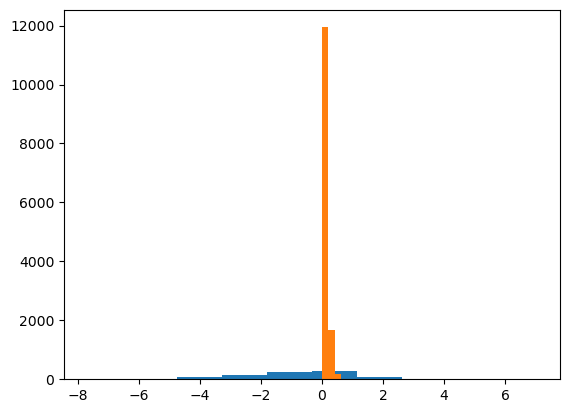

In [23]:
plt.hist(Y[0])
plt.hist(X[1][0])

In [24]:
from joblib import parallel_backend
from scipy.stats import zscore


start_time = time.time()
for i,layer in enumerate(all_layers):
    
    # Assuming X is your feature set and Y is the target variable
    X_train, X_test, Y_train, Y_test = train_test_split(X[i], Y, test_size=0.1, shuffle=False)

    Y_train = np.nan_to_num(zscore(Y_train))
    X_train = np.nan_to_num(zscore(X_train))
    X_test = np.nan_to_num(zscore(X_test))






    
    # Create a RidgeCV object
    ridge = RidgeCV(alphas=[ 1e-2, 1e-1, 1], cv=10)
    
    # Fit the model
    ridge.fit(X_train, Y_train)
    
    # Now you can use the model to predict the test set
    #_pred = ridge.predict(X_test)
    score = ridge.score(X_test, Y_test)
    print("R^2 Score: ", score)
    # clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X[i], Y)
    #print(clf.score(Y_test, Y_pred))
elapsed_time=time.time() - start_time
print(elapsed_time)


# start_time = time.time()

# with parallel_backend('loky',n_jobs=4):
#     for i,layer in enumerate(all_layers):
    
#         # Assuming X is your feature set and Y is the target variable
#         X_train, X_test, Y_train, Y_test = train_test_split(X[i], Y, test_size=0.2, random_state=42)
        
#         # Create a RidgeCV object
#         ridge = RidgeCV(alphas=[ 1e-2, 1e-1, 1], cv=10)
        
#         # Fit the model
#         ridge.fit(X_train, Y_train)
        
#         # Now you can use the model to predict the test set
#         #_pred = ridge.predict(X_test)
#         score = ridge.score(X_test, Y_test)
#         print("R^2 Score: ", score)
#         # clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X[i], Y)
#         #print(clf.score(Y_test, Y_pred))

# elapsed_time=time.time() - start_time
# print(elapsed_time)

/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=5.84073e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


R^2 Score:  -0.11198958612688421


/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=3.05122e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=3.48273e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=3.66792e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=3.94285e-09): result may not be accurate.
  dual_coef = linalg.sol

R^2 Score:  -0.10432352167918822
10.174534559249878


In [240]:
Y.shape

(739, 871)

In [241]:
X[0].shape

(739, 211)

In [32]:
# from joblib import parallel_backend

# start_time = time.time()
# with parallel_backend('loky', n_jobs=4):
#     # Your scikit-learn code here
#     r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'cross_val_ridge',n_folds =5,score_f=R2)
#     #r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'simple_ridge',n_folds =2,score_f=R2)
# elapsed_time=time.time() - start_time
# print(elapsed_time)

start_time = time.time()
# Your scikit-learn code here
#r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'cross_val_ridge',n_folds =5,score_f=R2)
r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'simple_ridge',n_folds =5,score_f=R2)
elapsed_time=time.time() - start_time
print(elapsed_time)

16.479061603546143


In [33]:
## r2s: voxelwise R2(predictions using only one feature, data)
print('shape of r2s is (number of features, dim_Y), that is', r2s.shape)

## stacked_r2s: voxelwise R2(stacking predictions using all features, data)
print('shape of stacked_r2s is (dim_Y, ), that is', stacked_r2s.shape)

## S_average: optimzed voxelwise stacking weights showing how different features are combined
print('shape of S_average is (dim_Y, num of features), that is', S_average.shape)

shape of r2s is (number of features, dim_Y), that is (2, 871)
shape of stacked_r2s is (dim_Y, ), that is (871,)
shape of S_average is (dim_Y, num of features), that is (871, 2)


In [34]:
np.mean(stacked_r2s)

0.009132769516833512

In [20]:
stacked_r2s.max()

0.014761484505819156

## make different types of features for fitting models and save them as npz to save time

### mean activations

In [23]:
import h5py
import numpy as np

# load the mean activations
all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool']

X=load_audio_features('DM',all_layers)
for x in X:
    print(x.shape)

# the mean PCA(1,5,10,50,100,200)
for n_components in [1,5,10,50,100,200]:
    X=nat_asd_utils.load_audio_features_PCA('DM',all_layers,n_components)
    with h5py.File(f'../data/features/DM_cochresnet50_activations-mean_PCA-{n_components}.hdf5', 'w') as f:
        for i, layer in enumerate(all_layers):
            f.create_dataset(layer, data=X[i])


(749, 211)
(749, 6784)
(749, 3392)
(749, 13568)
(749, 13824)
(749, 14336)
(749, 14336)
(749, 2048)
loading features 1 PCA components
loading features 5 PCA components
loading features 10 PCA components
loading features 50 PCA components
loading features 100 PCA components
loading features 200 PCA components


In [ ]:
## do the same for cneuromod

In [3]:
import h5py
import numpy as np
import nat_asd_utils
# load the mean activations

stim='friends_s01e02a'
all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool']

# X=load_audio_features('friends_s01e02a',all_layers)
# for x in X:
#     print(x.shape)

# the mean PCA(1,5,10,50,100,200)
for n_components in [1,10,100]:
    X=nat_asd_utils.load_audio_features_PCA(f'{stim}',all_layers,n_components)
    with h5py.File(f'../data/features/{stim}_cochresnet50_activations-mean_PCA-{n_components}.hdf5', 'w') as f:
        for i, layer in enumerate(all_layers):
            f.create_dataset(layer, data=X[i])


loading features 1 PCA components
loading features 10 PCA components
loading features 100 PCA components


In [6]:
X=nat_asd_utils.load_audio_features('friends_s01e02a',all_layers)

### full activations

In [41]:
# the full activations:

# the full activation, PCA across time
all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4']
for n_components in [1,10]:
    print(n_components)
    X=load_audio_features_PCA_new_full('DM',delay,all_layers,n_components)
    with h5py.File(f'../data/features/DM_cochresnet50_activations-full_PCA-local-{n_components}.hdf5', 'w') as f:
        for i, layer in enumerate(all_layers):
            f.create_dataset(layer, data=X[i])

# the full activation, PCA across time, mean across time
#can't do avg_pool becuase the 'time' dimension is 1...



1
0 input_after_preproc
input= (749, 211, 390)
after mean()= (749, 1, 390)
after flatten= (749, 390)
1 conv1_relu1
input= (749, 6784, 195)
after mean()= (749, 1, 195)
after flatten= (749, 195)
2 maxpool1
input= (749, 3392, 98)
after mean()= (749, 1, 98)
after flatten= (749, 98)
3 layer1
input= (749, 13568, 98)
after mean()= (749, 1, 98)
after flatten= (749, 98)
4 layer2
input= (749, 13824, 49)
after mean()= (749, 1, 49)
after flatten= (749, 49)
5 layer3
input= (749, 14336, 25)
after mean()= (749, 1, 25)
after flatten= (749, 25)
6 layer4
input= (749, 14336, 13)
after mean()= (749, 1, 13)
after flatten= (749, 13)
10
0 input_after_preproc
input= (749, 211, 390)
after mean()= (749, 10, 390)
after flatten= (749, 3900)
1 conv1_relu1
input= (749, 6784, 195)
after mean()= (749, 10, 195)
after flatten= (749, 1950)
2 maxpool1
input= (749, 3392, 98)
after mean()= (749, 10, 98)
after flatten= (749, 980)
3 layer1
input= (749, 13568, 98)
after mean()= (749, 10, 98)
after flatten= (749, 980)
4 layer2

In [39]:
all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4']

for n_components in [1,10]:
    print(n_components)
    X=load_audio_features_PCA_new_mean('DM',delay,all_layers,n_components)
    with h5py.File(f'../data/features/DM_cochresnet50_activations-full_PCA-local-{n_components}_mean.hdf5', 'w') as f:
        for i, layer in enumerate(all_layers):
            f.create_dataset(layer, data=X[i])



1
0 input_after_preproc
input= (749, 211, 390)
after mean(pca())= (749, 1)
after flatten= (749, 1)
1 conv1_relu1
input= (749, 6784, 195)
after mean(pca())= (749, 1)
after flatten= (749, 1)
2 maxpool1
input= (749, 3392, 98)
after mean(pca())= (749, 1)
after flatten= (749, 1)
3 layer1
input= (749, 13568, 98)
after mean(pca())= (749, 1)
after flatten= (749, 1)
4 layer2
input= (749, 13824, 49)
after mean(pca())= (749, 1)
after flatten= (749, 1)
5 layer3
input= (749, 14336, 25)
after mean(pca())= (749, 1)
after flatten= (749, 1)
6 layer4
input= (749, 14336, 13)
after mean(pca())= (749, 1)
after flatten= (749, 1)
10
0 input_after_preproc
input= (749, 211, 390)
after mean(pca())= (749, 10)
after flatten= (749, 10)
1 conv1_relu1
input= (749, 6784, 195)
after mean(pca())= (749, 10)
after flatten= (749, 10)
2 maxpool1
input= (749, 3392, 98)
after mean(pca())= (749, 10)
after flatten= (749, 10)
3 layer1
input= (749, 13568, 98)
after mean(pca())= (749, 10)
after flatten= (749, 10)
4 layer2
input= 

In [43]:
# the full flattened PCA

In [6]:
all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool']

X=load_audio_features_full(stim,all_layers)


from sklearn.decomposition import PCA
transformer = PCA(n_components=n_components)

for n_components in [1,5,10,50,100,200]:
    print('n_componentes',n_components)
    transformer = PCA(n_components=n_components)

    X_PCA=[]
    
    for xx in range(len(X)):
        transformer = PCA(n_components=n_components)
        
        data=X[xx]
        print(xx, data.shape)
        data=transformer.fit_transform(data)
        X_PCA.append(data)
        print(data.shape)
    
    with h5py.File(f'../data/features/DM_cochresnet50_activations-full_PCA-{n_components}.hdf5', 'w') as f:
        for i, layer in enumerate(all_layers):
            f.create_dataset(layer, data=X_PCA[i])

n_componentes 1
0 (749, 82290)
(749, 1)
1 (749, 1322880)
(749, 1)
2 (749, 332416)
(749, 1)
3 (749, 1329664)
(749, 1)
4 (749, 677376)
(749, 1)
5 (749, 358400)
(749, 1)
6 (749, 186368)
(749, 1)
7 (749, 2048)
(749, 1)
n_componentes 5
0 (749, 82290)
(749, 5)
1 (749, 1322880)
(749, 5)
2 (749, 332416)
(749, 5)
3 (749, 1329664)
(749, 5)
4 (749, 677376)
(749, 5)
5 (749, 358400)
(749, 5)
6 (749, 186368)
(749, 5)
7 (749, 2048)
(749, 5)
n_componentes 10
0 (749, 82290)
(749, 10)
1 (749, 1322880)
(749, 10)
2 (749, 332416)
(749, 10)
3 (749, 1329664)
(749, 10)
4 (749, 677376)
(749, 10)
5 (749, 358400)
(749, 10)
6 (749, 186368)
(749, 10)
7 (749, 2048)
(749, 10)
n_componentes 50
0 (749, 82290)
(749, 50)
1 (749, 1322880)
(749, 50)
2 (749, 332416)
(749, 50)
3 (749, 1329664)
(749, 50)
4 (749, 677376)
(749, 50)
5 (749, 358400)
(749, 50)
6 (749, 186368)
(749, 50)
7 (749, 2048)
(749, 50)
n_componentes 100
0 (749, 82290)
(749, 100)
1 (749, 1322880)
(749, 100)
2 (749, 332416)
(749, 100)
3 (749, 1329664)
(749, 

In [30]:
# Open the HDF5 file
#with h5py.File(f'../data/features/DM_cochresnet50_activations-mean_PCA-{n_components}.hdf5', 'r') as f:
with h5py.File(f'../data/features/DM_cochresnet50_activations-full_PCA-10.hdf5', 'r') as f:
    
    # Loop over all keys (i.e., layer names) in the file
    for key in f.keys():
        # Load the data for the current key into a numpy array
        data = f[key][...]

        # Now 'data' is a numpy array containing the data for the current layer
        print(f"{key}: {data.shape}")

avgpool: (749, 10)
conv1_relu1: (749, 10)
input_after_preproc: (749, 10)
layer1: (749, 10)
layer2: (749, 10)
layer3: (749, 10)
layer4: (749, 10)
maxpool1: (749, 10)


In [13]:

# load a (good) subject data, audio ROIs
atlas,atlas_data=nat_asd_utils.load_glasser()
sub="NDARHJ830RXD"
parcel='A1'
parcels=['A1',
    'A4',
    'A5']

atlas_indices,indices,parcel_names=nat_asd_utils.get_parcel_indices(atlas,parcels)
atlas_indices_indices = np.where(np.isin(atlas_data, atlas_indices))[0]

delay=7

im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y=img_y[delay:,atlas_indices_indices]

# load the audio features
all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool']

# all_layers=['input_after_preproc',
#  'conv1_relu1']

# all_layers=['input_after_preproc',
#  'layer2']

filename='DM_cochresnet50_activations-full_PCA-200.hdf5'
X=nat_asd_utils.load_audio_features_processed(filename,all_layers)

X = [array[:Y.shape[0], :] for array in X]
Y= Y[:X[0].shape[0],:]


In [14]:
X[0].shape

(739, 200)

In [15]:
Y.shape

(739, 871)

In [42]:
files = glob.glob(f'../data/features/*.hdf5')
for f in files:
    
    atlas,atlas_data=nat_asd_utils.load_glasser()
    sub="NDARHJ830RXD"
    parcel='A1'
    parcels=['A1',
        'A4',
        'A5']
    
    atlas_indices,indices,parcel_names=nat_asd_utils.get_parcel_indices(atlas,parcels)
    atlas_indices_indices = np.where(np.isin(atlas_data, atlas_indices))[0]
    
    delay=7
    
    im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
    img = nb.load(im_file)
    img_y = img.get_fdata()
    Y=img_y[delay:,atlas_indices_indices]
    
    # load the audio features
    all_layers=['input_after_preproc',
     'conv1_relu1',
     'maxpool1',
     'layer1',
     'layer2',
     'layer3',
     'layer4',
     'avgpool']

    all_layers=['input_after_preproc',
     'conv1_relu1',
     'maxpool1',
     'layer1',
     'layer2',
     'layer3',
     'layer4']
    
    # all_layers=['input_after_preproc',
    #  'conv1_relu1']
    
    # all_layers=['input_after_preproc',
    #  'layer2']
    
    #filename='DM_cochresnet50_activations-full_PCA-200.hdf5'
    filename=os.path.basename(f)
    print(filename)
    X=nat_asd_utils.load_audio_features_processed(filename,all_layers)
    
    X = [array[:Y.shape[0], :] for array in X]
    Y= Y[:X[0].shape[0],:]


    
    start_time = time.time()
    # Your scikit-learn code here
    #r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'cross_val_ridge',n_folds =5,score_f=R2)
    r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'simple_ridge',n_folds =5,score_f=R2)
    elapsed_time=time.time() - start_time
    print('time=',elapsed_time)
    print('R2=',np.mean(stacked_r2s))

DM_cochresnet50_activations-full_PCA-1.hdf5
time= 12.117755651473999
R2= 0.10015499786993952
DM_cochresnet50_activations-full_PCA-10.hdf5
time= 14.692841529846191
R2= 0.07537728795573245
DM_cochresnet50_activations-full_PCA-100.hdf5
time= 24.94187593460083
R2= 0.033468311030144936
DM_cochresnet50_activations-full_PCA-200.hdf5
time= 43.2307448387146
R2= 0.025784986974006288
DM_cochresnet50_activations-full_PCA-5.hdf5
time= 13.692887544631958
R2= 0.06998093249381906
DM_cochresnet50_activations-full_PCA-50.hdf5
time= 18.50237727165222
R2= 0.0340908982328968
DM_cochresnet50_activations-full_PCA-local-1.hdf5
time= 33.55470848083496
R2= -0.002008928436515227
DM_cochresnet50_activations-full_PCA-local-10.hdf5



KeyboardInterrupt



In [234]:
files = glob.glob(f'../data/features/*.hdf5')
for f in files[8:]:
    
    atlas,atlas_data=nat_asd_utils.load_glasser()
    sub="NDARHJ830RXD"
    parcel='A1'
    parcels=['A1',
        'A4',
        'A5']
    
    atlas_indices,indices,parcel_names=nat_asd_utils.get_parcel_indices(atlas,parcels)
    atlas_indices_indices = np.where(np.isin(atlas_data, atlas_indices))[0]
    
    delay=7
    
    im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
    img = nb.load(im_file)
    img_y = img.get_fdata()
    Y=img_y[delay:,atlas_indices_indices]
    
    # load the audio features
    all_layers=['input_after_preproc',
     'conv1_relu1',
     'maxpool1',
     'layer1',
     'layer2',
     'layer3',
     'layer4',
     'avgpool']

    all_layers=['input_after_preproc',
     'conv1_relu1',
     'maxpool1',
     'layer1',
     'layer2',
     'layer3',
     'layer4']
    
    # all_layers=['input_after_preproc',
    #  'conv1_relu1']
    
    # all_layers=['input_after_preproc',
    #  'layer2']
    
    #filename='DM_cochresnet50_activations-full_PCA-200.hdf5'
    filename=os.path.basename(f)
    print(filename)
    X=nat_asd_utils.load_audio_features_processed(filename,all_layers)
    
    X = [array[:Y.shape[0], :] for array in X]
    Y= Y[:X[0].shape[0],:]


    
    start_time = time.time()
    # Your scikit-learn code here
    #r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'cross_val_ridge',n_folds =5,score_f=R2)
    r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'simple_ridge',n_folds =5,score_f=R2)
    elapsed_time=time.time() - start_time
    print('time=',elapsed_time)
    print('R2=',np.mean(stacked_r2s))

DM_cochresnet50_activations-full_PCA-local-10_mean.hdf5
time= 6.7045578956604
R2= -0.001971727551897227
DM_cochresnet50_activations-full_PCA-local-1_mean.hdf5
time= 5.016804456710815
R2= -0.0025368459453350284
DM_cochresnet50_activations-mean_PCA-1.hdf5
time= 4.8745644092559814
R2= 0.10087191738594099
DM_cochresnet50_activations-mean_PCA-10.hdf5
time= 6.638021945953369
R2= 0.04933462404401908
DM_cochresnet50_activations-mean_PCA-100.hdf5
time= 14.792305946350098
R2= 0.01851887892487559
DM_cochresnet50_activations-mean_PCA-200.hdf5
time= 29.234883069992065
R2= 0.013629543673680748
DM_cochresnet50_activations-mean_PCA-5.hdf5
time= 6.023461580276489
R2= 0.07932351808643714
DM_cochresnet50_activations-mean_PCA-50.hdf5
time= 10.137935400009155
R2= 0.03346547548328273


full stacked does a little better than mean. but doing pca n=1, they are like the same

In [27]:
from joblib import parallel_backend
from scipy.stats import zscore



files = glob.glob(f'../data/features/*.hdf5')
for f in files:
    
    atlas,atlas_data=nat_asd_utils.load_glasser()
    sub="NDARHJ830RXD"
    parcel='A1'
    parcels=['A1',
        'A4',
        'A5']
    
    atlas_indices,indices,parcel_names=nat_asd_utils.get_parcel_indices(atlas,parcels)
    atlas_indices_indices = np.where(np.isin(atlas_data, atlas_indices))[0]
    
    delay=7
    
    im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
    img = nb.load(im_file)
    img_y = img.get_fdata()
    Y=img_y[delay:,atlas_indices_indices]
    
    # load the audio features
    all_layers=['input_after_preproc',
     'conv1_relu1',
     'maxpool1',
     'layer1',
     'layer2',
     'layer3',
     'layer4',
     'avgpool']

    all_layers=['input_after_preproc',
     'conv1_relu1',
     'maxpool1',
     'layer1',
     'layer2',
     'layer3',
     'layer4']
    
    # all_layers=['input_after_preproc',
    #  'conv1_relu1']
    
    # all_layers=['input_after_preproc',
    #  'layer2']
    
    #filename='DM_cochresnet50_activations-full_PCA-200.hdf5'
    filename=os.path.basename(f)
    print(filename)
    X=nat_asd_utils.load_audio_features_processed(filename,all_layers)
    
    X = [array[:Y.shape[0], :] for array in X]
    Y= Y[:X[0].shape[0],:]


    
    start_time = time.time()
    for i,layer in enumerate(all_layers):
        
        # Assuming X is your feature set and Y is the target variable
        X_train, X_test, Y_train, Y_test = train_test_split(X[i], Y, test_size=0.1, shuffle=False)
    
        Y_train = np.nan_to_num(zscore(Y_train))
        X_train = np.nan_to_num(zscore(X_train))
        X_test = np.nan_to_num(zscore(X_test))
    
    
    
    
    
    
        
        # Create a RidgeCV object
        ridge = RidgeCV(alphas=[ 1e-2, 1e-1, 1], cv=10)
        
        # Fit the model
        ridge.fit(X_train, Y_train)
        
        # Now you can use the model to predict the test set
        #_pred = ridge.predict(X_test)
        score = ridge.score(X_test, Y_test)
        print("R^2 Score: ", score)
        # clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X[i], Y)
        #print(clf.score(Y_test, Y_pred))
    elapsed_time=time.time() - start_time
    print(elapsed_time)

DM_cochresnet50_activations-full_PCA-1.hdf5
R^2 Score:  -0.04825883563435465
R^2 Score:  -0.0504559929443121
R^2 Score:  -0.04926190797742251
R^2 Score:  -0.06439740198983553
R^2 Score:  -0.001986528305274851
R^2 Score:  0.03614575880024234
R^2 Score:  0.03522944228996623
0.5193350315093994
DM_cochresnet50_activations-full_PCA-10.hdf5
R^2 Score:  -0.12735031011337228
R^2 Score:  -0.09957554471891619
R^2 Score:  -0.13572739232473455
R^2 Score:  -0.13240994637691336
R^2 Score:  -0.04248035894244044
R^2 Score:  -0.019348344900796333
R^2 Score:  -0.03985201814588713
0.5577099323272705
DM_cochresnet50_activations-full_PCA-100.hdf5
R^2 Score:  -0.11550569131844297
R^2 Score:  -0.14400259849305289
R^2 Score:  -0.13155510145859206
R^2 Score:  -0.15347946900102638
R^2 Score:  -0.15638709954786878
R^2 Score:  -0.1071209028491804
R^2 Score:  -0.18531346185101433
1.1140656471252441
DM_cochresnet50_activations-full_PCA-200.hdf5
R^2 Score:  -0.16943002663746023
R^2 Score:  -0.19084583547224104
R^2 S

/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=5.49847e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=5.07232e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=4.98906e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=5.13513e-08): result may not be accurate.
  dual_coef = linalg.sol

R^2 Score:  -0.6719794831773125
R^2 Score:  -0.9947876446255636
R^2 Score:  -2.695210643293624
R^2 Score:  -2.5584772225259167
R^2 Score:  -1.0734909525954999
R^2 Score:  -0.28487702442999785
R^2 Score:  -0.041091098785350694
8.346318006515503
DM_cochresnet50_activations-full_PCA-local-10_mean.hdf5
R^2 Score:  -0.01763859654348164
R^2 Score:  -0.03192898235498137
R^2 Score:  -0.022996253786580725
R^2 Score:  -0.02057353370165561
R^2 Score:  -0.02720990883309519
R^2 Score:  -0.0114975906065318
R^2 Score:  -0.02000478633186901
0.5406734943389893
DM_cochresnet50_activations-full_PCA-local-1_mean.hdf5
R^2 Score:  -0.013034120034639924
R^2 Score:  -0.014819795324787461
R^2 Score:  -0.014123952247268586
R^2 Score:  -0.01497136449604449
R^2 Score:  -0.013422215491317372
R^2 Score:  -0.010374088968607162
R^2 Score:  -0.026261603883800423
0.48555850982666016
DM_cochresnet50_activations-mean_PCA-1.hdf5
R^2 Score:  -0.048243017223944494
R^2 Score:  -0.05042127420053908
R^2 Score:  -0.049078723308

## try the other pliers features

In [159]:
import hrf_tools

import importlib

# Modify your_module here

# Now, reload it
importlib.reload(hrf_tools)


df=pd.read_csv('../data/DM_pliers_all.csv')

columns_list = df.columns.tolist()
print(columns_list)

from scipy.signal import resample

df = df[['rms', 'as-Speech', 'speech']]
columns_list = df.columns.tolist()
print(columns_list)

#load features from pliers
#df=pd.read_csv('../sourcedata/data/HBN/features/DM_pliers_all.csv',index_col=0)

X = df.to_numpy()

#X_hrf=hrf_tools.apply_optimal_hrf_10hz(X,1.25)
X_hrf=X
#resample to math TRs of 0.8 n=750 time points
X_res = []
for x in X_hrf.T:
    X_res.append(
        resample(x,750)
    )
X_res = np.array(X_res)

#zscore each feature 
X_z = zscore(X_res,axis=1)

['Unnamed: 0', 'brightness', 'sharpness', 'face_detectionConfidence', 'face_landmarkingConfidence', 'abstract', 'action', 'alphabet', 'animal', 'architecture', 'art', 'blur', 'building', 'business', 'car', 'child', 'city', 'color', 'competition', 'creativity', 'dark', 'daylight', 'design', 'desktop', 'empty', 'equipment', 'face', 'family', 'fashion', 'furniture', 'girl', 'hand', 'home', 'horizontal', 'illustration', 'image', 'indoors', 'landscape', 'light', 'man', 'military', 'music', 'nature', 'old', 'one', 'outdoors', 'pattern', 'people', 'portrait', 'recreation', 'retro', 'road', 'room', 'simplicity', 'sky', 'street', 'summer', 'sunset', 'technology', 'text', 'travel', 'two', 'vehicle', 'vertical', 'water', 'wear', 'wild', 'wildlife', 'woman', 'wood', 'writing', 'num_faces', 'speech', 'shot_change', 'text_length', 'fake_text_length', 'fake_Conc.M', 'fake_Duration', 'fake_FreqCOCAspok', 'fake_NumPhones', 'fake_NumSylls', 'fake_PhonLev', 'log_mean_face_time_cum', 'face_count', 'log_me

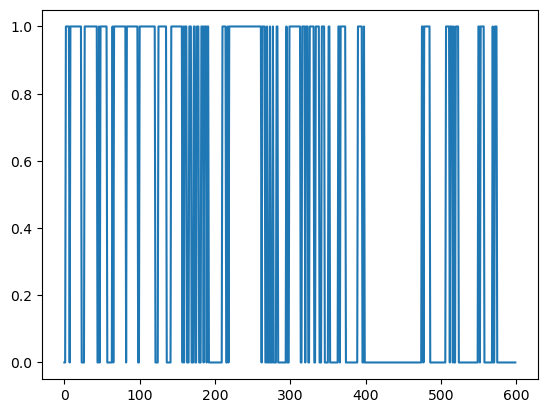

In [160]:
plt.plot(X_hrf[:,2])

In [161]:
X_z.shape

(3, 750)

In [162]:
im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y=img_y[delay:,atlas_indices_indices]
Y.shape

(738, 871)

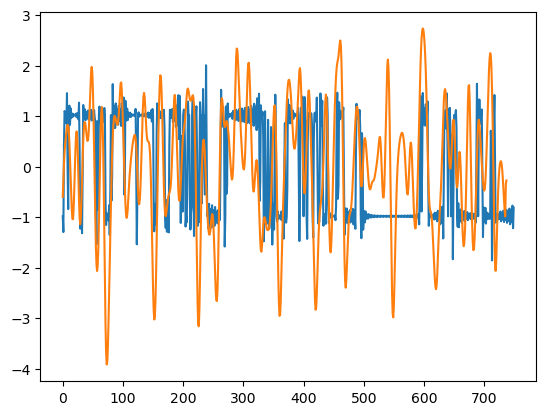

In [163]:
#plt.plot(df['rms'])
plt.plot(X_z[2])
plt.plot(Y.mean(axis=1))

In [180]:
from joblib import parallel_backend
from scipy.stats import zscore
from scipy.signal import resample




atlas,atlas_data=nat_asd_utils.load_glasser()
sub="NDARHJ830RXD"
parcel='A1'
parcels=['A1',
    'A4',
    'A5']

delay=6
atlas_indices,indices,parcel_names=nat_asd_utils.get_parcel_indices(atlas,parcels)
atlas_indices_indices = np.where(np.isin(atlas_data, atlas_indices))[0]
for f in ['rms','chroma', 'mfcc', 'mfs', 'as_embed', 'as_scores']:
    
    feature=np.load(f'../data/features/DM_{f}.npy')
    feat_x = resample(feature, 750, axis=0) #resample to 1hz for now 
    
    im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
    img = nb.load(im_file)
    img_y = img.get_fdata()
    Y=img_y[delay:,atlas_indices_indices]
    X=feat_x
    #X = [array[:Y.shape[0], :] for array in X]
    Y= Y[:X.shape[0],:]
    
    X = X[:Y.shape[0], :]
    print(X.shape, Y.shape)
    #Y= Y[:X[0].shape[0],:]
    start_time = time.time()
    
    
    # Assuming X is your feature set and Y is the target variable
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)
    
    Y_train = np.nan_to_num(zscore(Y_train))
    X_train = np.nan_to_num(zscore(X_train))
    X_test = np.nan_to_num(zscore(X_test))
    
    
    
    
    
    
    
    # Create a RidgeCV object
    ridge = RidgeCV(alphas=[ 1e-2, 1e-1, 1], cv=10)
    
    # Fit the model
    ridge.fit(X_train, Y_train)
    
    # Now you can use the model to predict the test set
    #_pred = ridge.predict(X_test)
    score = ridge.score(X_test, Y_test)
    print("R^2 Score: ", score)
    # clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X[i], Y)
    #print(clf.score(Y_test, Y_pred))
    elapsed_time=time.time() - start_time
    print(elapsed_time)

(740, 1) (740, 871)
R^2 Score:  -0.01840150873276562
0.07065057754516602
(740, 12) (740, 871)
R^2 Score:  -0.032910409219031565
0.07839155197143555
(740, 13) (740, 871)
R^2 Score:  -0.027740252894210456
0.07991933822631836
(740, 128) (740, 871)
R^2 Score:  -0.21776951067391165
0.18854951858520508
(740, 1024) (740, 871)


/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=5.63537e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=5.93392e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=5.72365e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:241: LinAlgWarning: Ill-conditioned matrix (rcond=7.55017e-09): result may not be accurate.
  dual_coef = linalg.sol

R^2 Score:  -1.9572540135300458
1.216590404510498
(740, 521) (740, 871)


/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.9793e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.44665e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.60351e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/om2/user/jsmentch/anaconda/envs/hbn_asd/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=2.63527e-08): result may not be accurate.
  return linalg.solve(A, Xy, assum

R^2 Score:  -3.5358436818279904
0.7852649688720703


In [285]:
features

['rms', 'chroma', 'mfcc', 'mfs', 'as_embed', 'as_scores']

## try manually extracted audio features

In [296]:


from sklearn.decomposition import PCA
n_components=1
from sklearn.preprocessing import StandardScaler

    

    
delay=6

from scipy.signal import resample
X=[]
features=['rms','chroma', 'mfcc', 'mfs', 'as_embed', 'as_scores']
for f in features:
    feature=np.load(f'../data/features/DM_{f}.npy')
    #print(feature.shape)
    # transformer = PCA(n_components=n_components)
    scaler = StandardScaler()
    # feature=transformer.fit_transform(feature)
    feature = scaler.fit_transform(X=feature,y=None)
    #print(feature.shape)
    feat_x = resample(feature, 750, axis=0) #resample to 1hz for now 
    X.append(feat_x)
    #print(feat_x.shape)

im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y=img_y[delay:,atlas_indices_indices]
#X=feat_x
#X = [array[:Y.shape[0], :] for array in X]

X = [array[:Y.shape[0], :] for array in X]
Y= Y[:X[0].shape[0],:]    
print(X[0].shape, Y.shape)

start_time = time.time()
# Your scikit-learn code here
#r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'cross_val_ridge',n_folds =5,score_f=R2)
r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'simple_ridge',n_folds =5,score_f=R2)
elapsed_time=time.time() - start_time
print('time=',elapsed_time)
print('R2=',np.mean(stacked_r2s))

(740, 1) (740, 728)
time= 104.97616171836853
R2= 0.06528982462110652


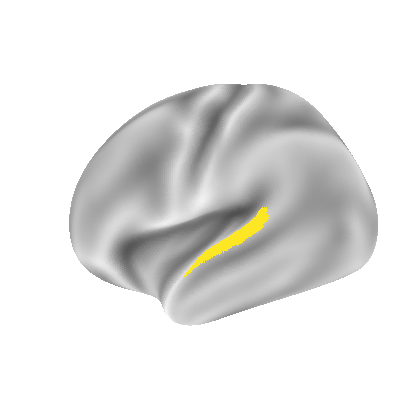

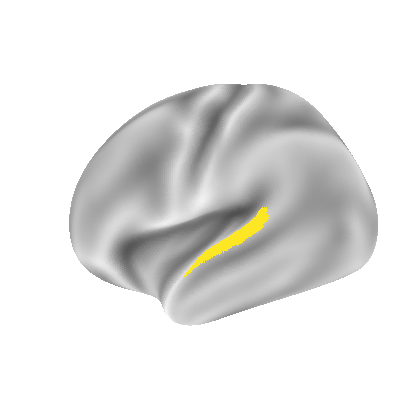

In [297]:
#f=f'{temp_dir}feat-{feat}_sub-{sub}_ROI-{ROI}_PCA-{PCA}_delay-{delay}.npz'
#data=np.load(f)
import matplotlib.pyplot as plt
import seaborn as sns

import nilearn.plotting as plotting
import hcp_utils as hcp


sub_data=np.argmax(S_average,axis=1)

#sub_data[bh_corrected > 0.05] = 0

data_to_plot=sub_data

parcel=parcels

all_brain=np.zeros(atlas_data.shape)

for i, ind in enumerate(atlas_indices_indices):
    all_brain[ind]=data_to_plot[i]
    
roi_indices,indices_,roi_names=nat_asd_utils.get_parcel_indices(atlas,parcel) #get indices of V1
roi_indices_indices = np.where(np.isin(atlas_data, roi_indices))[0]


plot_roi=np.zeros(atlas_data.shape)
for i, roi_ind in enumerate(roi_indices_indices):
    plot_roi[roi_ind]=all_brain[roi_ind]
roi_data=plot_roi[roi_indices_indices]

plotting.plot_surf(hcp.mesh.very_inflated, hcp.cortex_data(plot_roi), 
    threshold=0.001,bg_map=hcp.mesh.sulc,cmap='viridis',symmetric_cmap=False,avg_method='median')

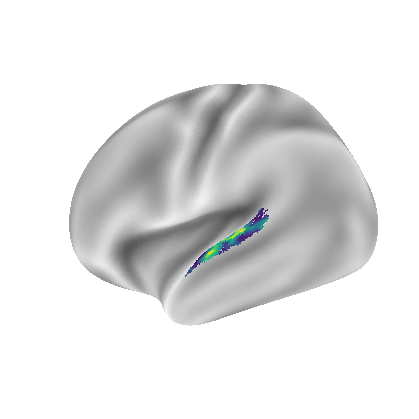

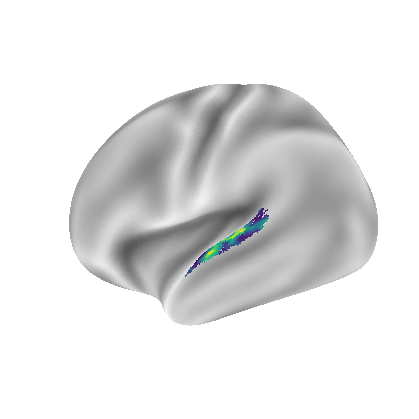

In [298]:
#f=f'{temp_dir}feat-{feat}_sub-{sub}_ROI-{ROI}_PCA-{PCA}_delay-{delay}.npz'
#data=np.load(f)
import matplotlib.pyplot as plt
import seaborn as sns

import nilearn.plotting as plotting
import hcp_utils as hcp


sub_data=np.argmax(S_average,axis=1)
sub_data=stacked_r2s

#sub_data[bh_corrected > 0.05] = 0

data_to_plot=sub_data

parcel=parcels

all_brain=np.zeros(atlas_data.shape)

for i, ind in enumerate(atlas_indices_indices):
    all_brain[ind]=data_to_plot[i]
    
roi_indices,indices_,roi_names=nat_asd_utils.get_parcel_indices(atlas,parcel) #get indices of V1
roi_indices_indices = np.where(np.isin(atlas_data, roi_indices))[0]


plot_roi=np.zeros(atlas_data.shape)
for i, roi_ind in enumerate(roi_indices_indices):
    plot_roi[roi_ind]=all_brain[roi_ind]
roi_data=plot_roi[roi_indices_indices]

plotting.plot_surf(hcp.mesh.very_inflated, hcp.cortex_data(plot_roi), 
    threshold=0.001,bg_map=hcp.mesh.sulc,cmap='viridis',symmetric_cmap=False,avg_method='median')

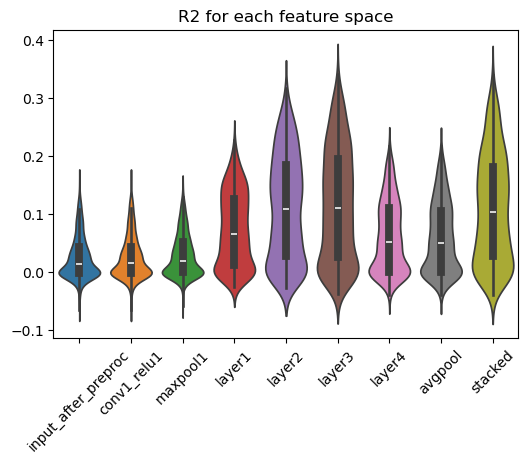

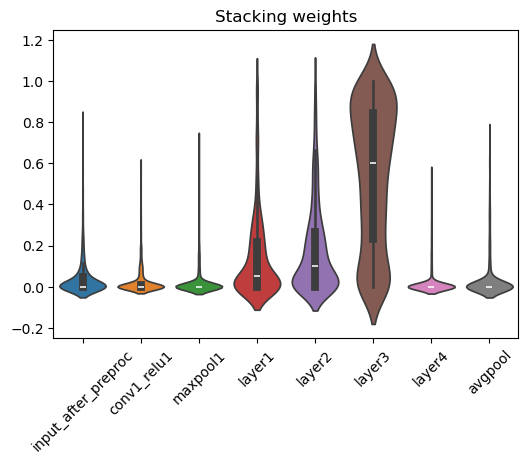

In [303]:
plot_data=np.concatenate((r2s, stacked_r2s.reshape(1, -1)), axis=0).T

plt.figure(figsize=(6,4))
ax=sns.violinplot(data=plot_data)
#    plt.xticks(np.arange(24), ['Subject'+str(k+1) for k in range(24)])
plt.title(f'R2 for each feature space')
features=all_layers
#features=['rms','chroma', 'mfcc', 'mfs', 'as_embed', 'as_scores']

# Add 'stacked' to the end of your features list
labels = features + ['stacked']

# Set the xticklabels of your plot
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels,rotation=45)
plt.show()

plt.figure(figsize=(6,4))
ax=sns.violinplot(data=S_average)
#    plt.xticks(np.arange(24), ['Subject'+str(k+1) for k in range(24)])
#plt.title(f'Violin plot of the subjects by delay for brain region {parcel_names[j]}')
labels = features
plt.title(f'Stacking weights')

# Set the xticklabels of your plot
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels,rotation=45)
plt.show()

In [300]:
f='DM_cochresnet50_activations-mean_PCA-1.hdf5'

atlas,atlas_data=nat_asd_utils.load_glasser()
sub="NDARHJ830RXD"
parcel='A1'

parcels=['A1',
    'A4',
    'A5']

parcels=['A4',
    'A5']

atlas_indices,indices,parcel_names=nat_asd_utils.get_parcel_indices(atlas,parcels)
atlas_indices_indices = np.where(np.isin(atlas_data, atlas_indices))[0]

delay=7
for delay in [3,4,5,6,7]:
    print('delay ',delay)
    im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
    img = nb.load(im_file)
    img_y = img.get_fdata()
    Y=img_y[delay:,atlas_indices_indices]
    
    # load the audio features
    all_layers=['input_after_preproc',
     'conv1_relu1',
     'maxpool1',
     'layer1',
     'layer2',
     'layer3',
     'layer4',
     'avgpool']
    
    
    # all_layers=['input_after_preproc',
    #  'conv1_relu1']
    
    # all_layers=['input_after_preproc',
    #  'layer2']
    
    #filename='DM_cochresnet50_activations-full_PCA-200.hdf5'
    filename=os.path.basename(f)
    print(filename)
    X=nat_asd_utils.load_audio_features_processed(filename,all_layers)
    
    X = [array[:Y.shape[0], :] for array in X]
    Y= Y[:X[0].shape[0],:]
    
    
    
    start_time = time.time()
    # Your scikit-learn code here
    #r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'cross_val_ridge',n_folds =5,score_f=R2)
    r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'simple_ridge',n_folds =5,score_f=R2)
    elapsed_time=time.time() - start_time
    print('time=',elapsed_time)
    print('R2=',np.mean(stacked_r2s))

delay  3
DM_cochresnet50_activations-mean_PCA-1.hdf5
time= 4.5058228969573975
R2= 0.03790037983211839
delay  4
DM_cochresnet50_activations-mean_PCA-1.hdf5
time= 4.294454097747803
R2= 0.06335039695894185
delay  5
DM_cochresnet50_activations-mean_PCA-1.hdf5
time= 4.254358768463135
R2= 0.08752629667890746
delay  6
DM_cochresnet50_activations-mean_PCA-1.hdf5
time= 4.2989771366119385
R2= 0.10444470520067346
delay  7
DM_cochresnet50_activations-mean_PCA-1.hdf5
time= 4.29764461517334
R2= 0.1107956518251184


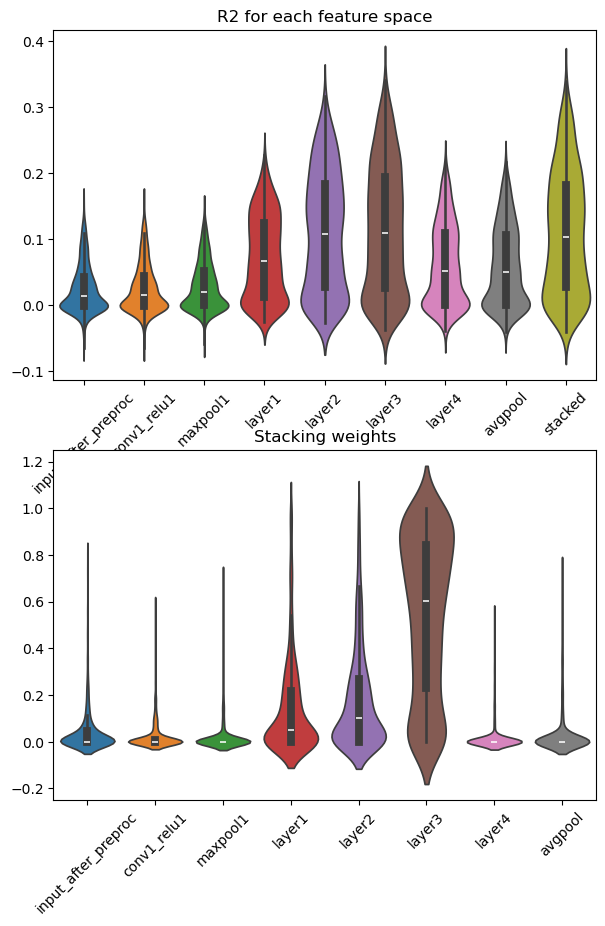

<Figure size 600x400 with 0 Axes>

In [323]:
plot_data=np.concatenate((r2s, stacked_r2s.reshape(1, -1)), axis=0).T


fig, axs = plt.subplots(2, figsize=(7, 10))
axs = axs.flatten()

#plt.figure(figsize=(6,4))
sns.violinplot(data=plot_data,ax=axs[0])
#    plt.xticks(np.arange(24), ['Subject'+str(k+1) for k in range(24)])
#plt.title(f'R2 for each feature space')
axs[0].set_title(f'R2 for each feature space')

features=all_layers
#features=['rms','chroma', 'mfcc', 'mfs', 'as_embed', 'as_scores']

# Add 'stacked' to the end of your features list
labels = features + ['stacked']

# Set the xticklabels of your plot
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels,rotation=45)

plt.figure(figsize=(6,4))
sns.violinplot(data=S_average,ax=axs[1])
#    plt.xticks(np.arange(24), ['Subject'+str(k+1) for k in range(24)])
#plt.title(f'Violin plot of the subjects by delay for brain region {parcel_names[j]}')
labels = features
axs[1].set_title(f'Stacking weights')

# Set the xticklabels of your plot
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels,rotation=45)

fig.savefig('../plots/my_figure.png')

## make braain plots:

# import matplotlib.pyplot as plt
# import seaborn as sns

# import nilearn.plotting as plotting
# import hcp_utils as hcp


# sub_data=np.argmax(S_average,axis=1)
# sub_data=stacked_r2s

# #sub_data[bh_corrected > 0.05] = 0

# data_to_plot=sub_data

# parcel=parcels

# all_brain=np.zeros(atlas_data.shape)

# for i, ind in enumerate(atlas_indices_indices):
#     all_brain[ind]=data_to_plot[i]
    
# roi_indices,indices_,roi_names=nat_asd_utils.get_parcel_indices(atlas,parcel) #get indices of V1
# roi_indices_indices = np.where(np.isin(atlas_data, roi_indices))[0]


# plot_roi=np.zeros(atlas_data.shape)
# for i, roi_ind in enumerate(roi_indices_indices):
#     plot_roi[roi_ind]=all_brain[roi_ind]
# roi_data=plot_roi[roi_indices_indices]

# plotting.plot_surf(hcp.mesh.very_inflated, hcp.cortex_data(plot_roi), 
#     threshold=0.001,bg_map=hcp.mesh.sulc,cmap='viridis',symmetric_cmap=False,avg_method='median', view='lateral', colorbar=True)
# plotting.plot_surf(hcp.mesh.very_inflated, hcp.cortex_data(plot_roi), 
#     threshold=0.001,bg_map=hcp.mesh.sulc,cmap='viridis',symmetric_cmap=False,avg_method='median', view='medial', colorbar=True)

### HRF?

In [5]:
# canonical HRF
# other?

## compare to demographics

In [2]:
import os
import glob
from pathlib import Path
#from dotenv import load_dotenv
import pandas as pd
import numpy as np
# import dask.dataframe as dd
# import dask.bag as db

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
nat_img_dir='/nese/mit/group/sig/projects/naturalistic/nat_img/'
all_qc = pd.read_csv(  f"../data/all_qc.csv"  )

In [4]:
def get_imaging_site(identifier):
    path = f'/nese/mit/group/sig/projects/hbn/hbn_bids/sub-{identifier}/'
    if os.path.isdir(path + 'ses-HBNsiteRU'):
        return 'HBNsiteRU'
    elif os.path.isdir(path + 'ses-HBNsiteCBIC'):
        return 'HBNsiteCBIC'
    elif os.path.isdir(path + 'ses-HBNsiteSI'):
        return 'HBNsiteSI'
    elif os.path.isdir(path + 'ses-HBNsiteCUNY'):
        return 'HBNsiteCUNY'
    else:
        return None
        
dx_final=pd.read_csv(f'{nat_img_dir}sourcedata/data/HBN/phenotype/parsed/dx_onehot.csv')
dx_final['imaging_site'] = dx_final['Identifiers'].apply(get_imaging_site)

filtered_df = dx_final[dx_final['Autism Spectrum Disorder'] == 1]
asd_df = filtered_df[['Identifiers','imaging_site']].rename(columns={'Identifiers': 'subj_id'})
asd_df['subj_id'] = 'sub-' + asd_df['subj_id'].astype(str)

filtered_df = dx_final[dx_final['No Diagnosis Given'] == 1]
nt_df = filtered_df[['Identifiers','imaging_site']].rename(columns={'Identifiers': 'subj_id'})
nt_df['subj_id'] = 'sub-' + nt_df['subj_id'].astype(str)

filtered_df = dx_final[(dx_final['No Diagnosis Given'] == 0) & (dx_final['Autism Spectrum Disorder'] == 0)]
pilot_df = filtered_df[['Identifiers','imaging_site']].rename(columns={'Identifiers': 'subj_id'})
pilot_df['subj_id'] = 'sub-' + pilot_df['subj_id'].astype(str)

In [ ]:
dx_final

In [5]:
'''
I want a dataframe which has:

from all_qc
- only the relaxed filtered subjects
- only task==DM

from dx_final:
- a 'case' column where ASD (1) and controls (0), others (-1)
- only ses==RU
'''

dx_final_ru = dx_final[dx_final['imaging_site'] == 'HBNsiteRU']

def assign_class(row):
    if row['Autism Spectrum Disorder'] == 1:
        return 1
    elif row['No Diagnosis Given'] == 1:
        return 0
    else:
        return -1

dx_final_ru['class'] = dx_final_ru.apply(assign_class, axis=1)

all_qc_ru_dm = all_qc[all_qc['ses'] == 'HBNsiteRU']
all_qc_ru_dm = all_qc_ru_dm[all_qc_ru_dm['task'] == 'movieDM']
all_qc_ru_dm = all_qc_ru_dm[all_qc_ru_dm['relaxed_fd50'] == 1]

#get the common subjects between these dataframes
dx_final_ru = dx_final_ru[dx_final_ru['Identifiers'].isin(all_qc_ru_dm['sub'])]


/tmp/ipykernel_1116813/837493429.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dx_final_ru['class'] = dx_final_ru.apply(assign_class, axis=1)


In [8]:
all_qc_ru_dm.columns

Index(['aor', 'aqi', 'bids_meta', 'dummy_trs', 'dvars_nstd', 'dvars_std',
       'dvars_vstd', 'efc', 'fber', 'fd_mean', 'fd_num', 'fd_perc', 'fwhm_avg',
       'fwhm_x', 'fwhm_y', 'fwhm_z', 'gcor', 'gsr_x', 'gsr_y', 'provenance',
       'size_t', 'size_x', 'size_y', 'size_z', 'snr', 'spacing_tr',
       'spacing_x', 'spacing_y', 'spacing_z', 'summary_bg_k', 'summary_bg_mad',
       'summary_bg_mean', 'summary_bg_median', 'summary_bg_n',
       'summary_bg_p05', 'summary_bg_p95', 'summary_bg_stdv', 'summary_fg_k',
       'summary_fg_mad', 'summary_fg_mean', 'summary_fg_median',
       'summary_fg_n', 'summary_fg_p05', 'summary_fg_p95', 'summary_fg_stdv',
       'tsnr', 'subj_id', 'run_bad', 'ses', 'sub', 'task', 'relaxed_fd50',
       'dorit_fd40'],
      dtype='object')

In [9]:
#for sub in subjects list
with open('pilots_ru_dm_list.txt', 'r') as file:
    sub_list = file.readlines()
sub_list = [line.strip() for line in sub_list]

#get the r2 mean value for each subject
#get the motion and demographics for each subject

#make a plot where each subject has bars for these values

In [7]:
all_qc_ru_dm.loc[all_qc['sub'] == sub, 'fd_perc'].values

NameError: name 'sub' is not defined

In [10]:
stackedr2_list=[]
mean_stackedr2_list=[]
fd_mean_list=[]
fd_num_list=[]
fd_perc_list=[]
tsnr_list=[]
for sub in sub_list:
#sub=sub_list[0]
    loaded=np.load(f'../pilot_results/feat-audio_sub-{sub}_ROI-all_PCA-1_delay-6.npz')
    stackedr2_list.append(loaded['stacked_r2s'])
    mean_stackedr2_list.append(loaded['stacked_r2s'].mean())
    fd_mean_list.append(all_qc_ru_dm.loc[all_qc['sub'] == sub, 'fd_mean'].values[0])
    fd_num_list.append(all_qc_ru_dm.loc[all_qc['sub'] == sub, 'fd_num'].values[0])
    fd_perc_list.append(all_qc_ru_dm.loc[all_qc['sub'] == sub, 'fd_perc'].values[0])
    tsnr_list.append(all_qc_ru_dm.loc[all_qc['sub'] == sub, 'tsnr'].values[0])

## see how kwyk works 

In [11]:
import os
import json

# Directory containing your JSON files
directory = '/path/to/your/json/files'

# List to store uncertainties
uncertainties = []

# Loop through all files in the directory
for sub in sub_list:

    filepath = f'/om2/scratch/tmp/jsmentch/kwyk/{sub}_uncertainty.json'
    
    # Open and read the JSON file
    with open(filepath, 'r') as file:
        data = json.load(file)
        # Extract the uncertainty value
        uncertainty = data.get('uncertainty')
        if uncertainty is not None:
            uncertainties.append(uncertainty)

print(uncertainties)


[0.30114851592082753, 0.38846302411653666, 0.4476855959204876, 0.3442686029046487, 0.3310757183574656, 0.3599326493265152, 0.40894760105765554, 0.34011648991826915, 0.3542825754091647, 0.3667332405505829, 0.35450136198406035, 0.37990643817765496, 0.36695809532013723, 0.3801996134947518, 0.3337692839219906, 0.4528292088769268, 0.36541305142474517, 0.40582511036650853, 0.30042720941014567, 0.3767570921794444, 0.37565557348795653, 0.39930204219637466, 0.34367377903355906, 0.3954519657978831, 0.359614493508545, 0.38782091048174616]


In [32]:
np.mean(uncertainties)

0.37002920165940706

In [21]:
[u/max(uncertainties) for u in uncertainties]

[0.6650377449540271,
 0.857857701096565,
 0.9886411634770734,
 0.7602614764150882,
 0.7311271266678553,
 0.7948529871100702,
 0.9030945730552515,
 0.7510922070636757,
 0.7823757135451352,
 0.8098709918914623,
 0.7828588682767796,
 0.8389618662627143,
 0.81036754724864,
 0.8396092964888341,
 0.7370754301600383,
 1.0,
 0.80695556793038,
 0.8961990578589347,
 0.6634448562963569,
 0.8320070454683107,
 0.8295745197612792,
 0.881793917814387,
 0.7589479041908828,
 0.8732916473710995,
 0.7941503914918254,
 0.8564396970848913]

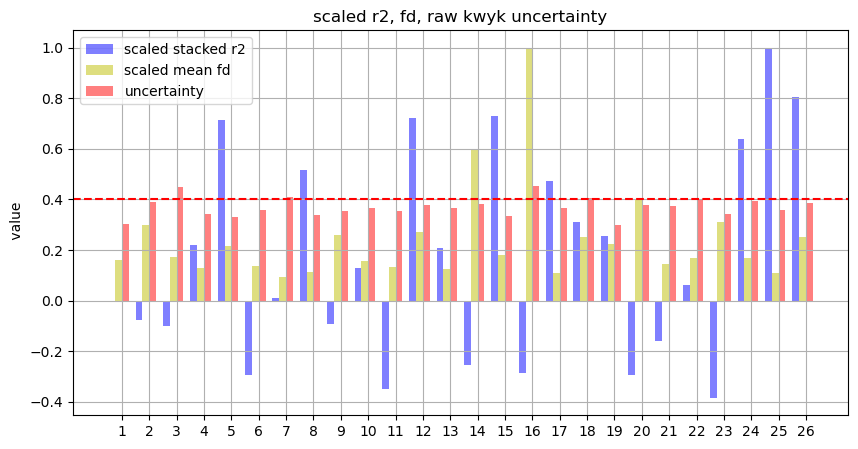

In [35]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have 3 lists of length 20
list1 = mean_stackedr2_list/max(mean_stackedr2_list)
list2 = fd_mean_list/max(fd_mean_list)
list3 = tsnr_list/max(tsnr_list)
list4= [u/max(uncertainties) for u in uncertainties]

list4= uncertainties

# Setting the positions and width for the bars
pos = list(range(len(list1))) 
width = 0.25 

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with list1 data,
# in position pos,
plt.bar(pos, 
        list1, 
        width, 
        alpha=0.5, 
        color='b',
        label='scaled stacked r2') 

# Create a bar with list2 data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        list2, 
        width, 
        alpha=0.5, 
        color='y', 
        label='scaled mean fd') 

# Create a bar with list3 data,
# in position pos + some width buffer,
plt.bar([p + width*2 for p in pos], 
        list4, 
        width, 
        alpha=0.5, 
        color='r', 
        label='uncertainty') 

# Set the y axis label
ax.set_ylabel(' value')

# Set the chart's title
ax.set_title('scaled r2, fd, raw kwyk uncertainty')

# Set the position of the x ticks
ax.set_xticks([p + 1.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(range(1,27))

# Adding the legend and showing the plot
plt.legend(['scaled stacked r2', 'scaled mean fd', 'uncertainty'], loc='upper left')
plt.grid()
plt.axhline(y=0.4, color='red', linestyle='--')

plt.show()

In [16]:
np.asanyarray(stackedr2_list).shape

(26, 12685)

In [17]:
## how correlated is each metric with the R2?

In [28]:
features_df = all_qc_ru_dm[all_qc_ru_dm['sub'].isin(sub_list)]


features=['sub','aor', 'aqi', 'dummy_trs', 'dvars_nstd', 'dvars_std',
       'dvars_vstd', 'efc', 'fber', 'fd_mean', 'fd_num', 'fd_perc', 'fwhm_avg',
       'fwhm_x', 'fwhm_y', 'fwhm_z', 'gcor', 'gsr_x', 'gsr_y', 
       'size_t', 'snr', 
       'spacing_x', 'spacing_y', 'spacing_z', 'summary_bg_k', 'summary_bg_mad',
       'summary_bg_mean', 'summary_bg_median', 'summary_bg_n',
       'summary_bg_p05', 'summary_bg_p95', 'summary_bg_stdv', 'summary_fg_k',
       'summary_fg_mad', 'summary_fg_mean', 'summary_fg_median',
       'summary_fg_n', 'summary_fg_p05', 'summary_fg_p95', 'summary_fg_stdv',
       'tsnr']
features_df=features_df[features]



value_dict = dict(zip(sub_list, mean_stackedr2_list))

# Then you can create a new column in df where the values are mapped according to the 'subject' column
features_df['r2'] = features_df['sub'].map(value_dict)



# features_df['r2'] = mean_stackedr2_list

features_numeric=features_df.drop('sub', axis=1)

In [30]:
features_numeric['uncertainty'] = uncertainties


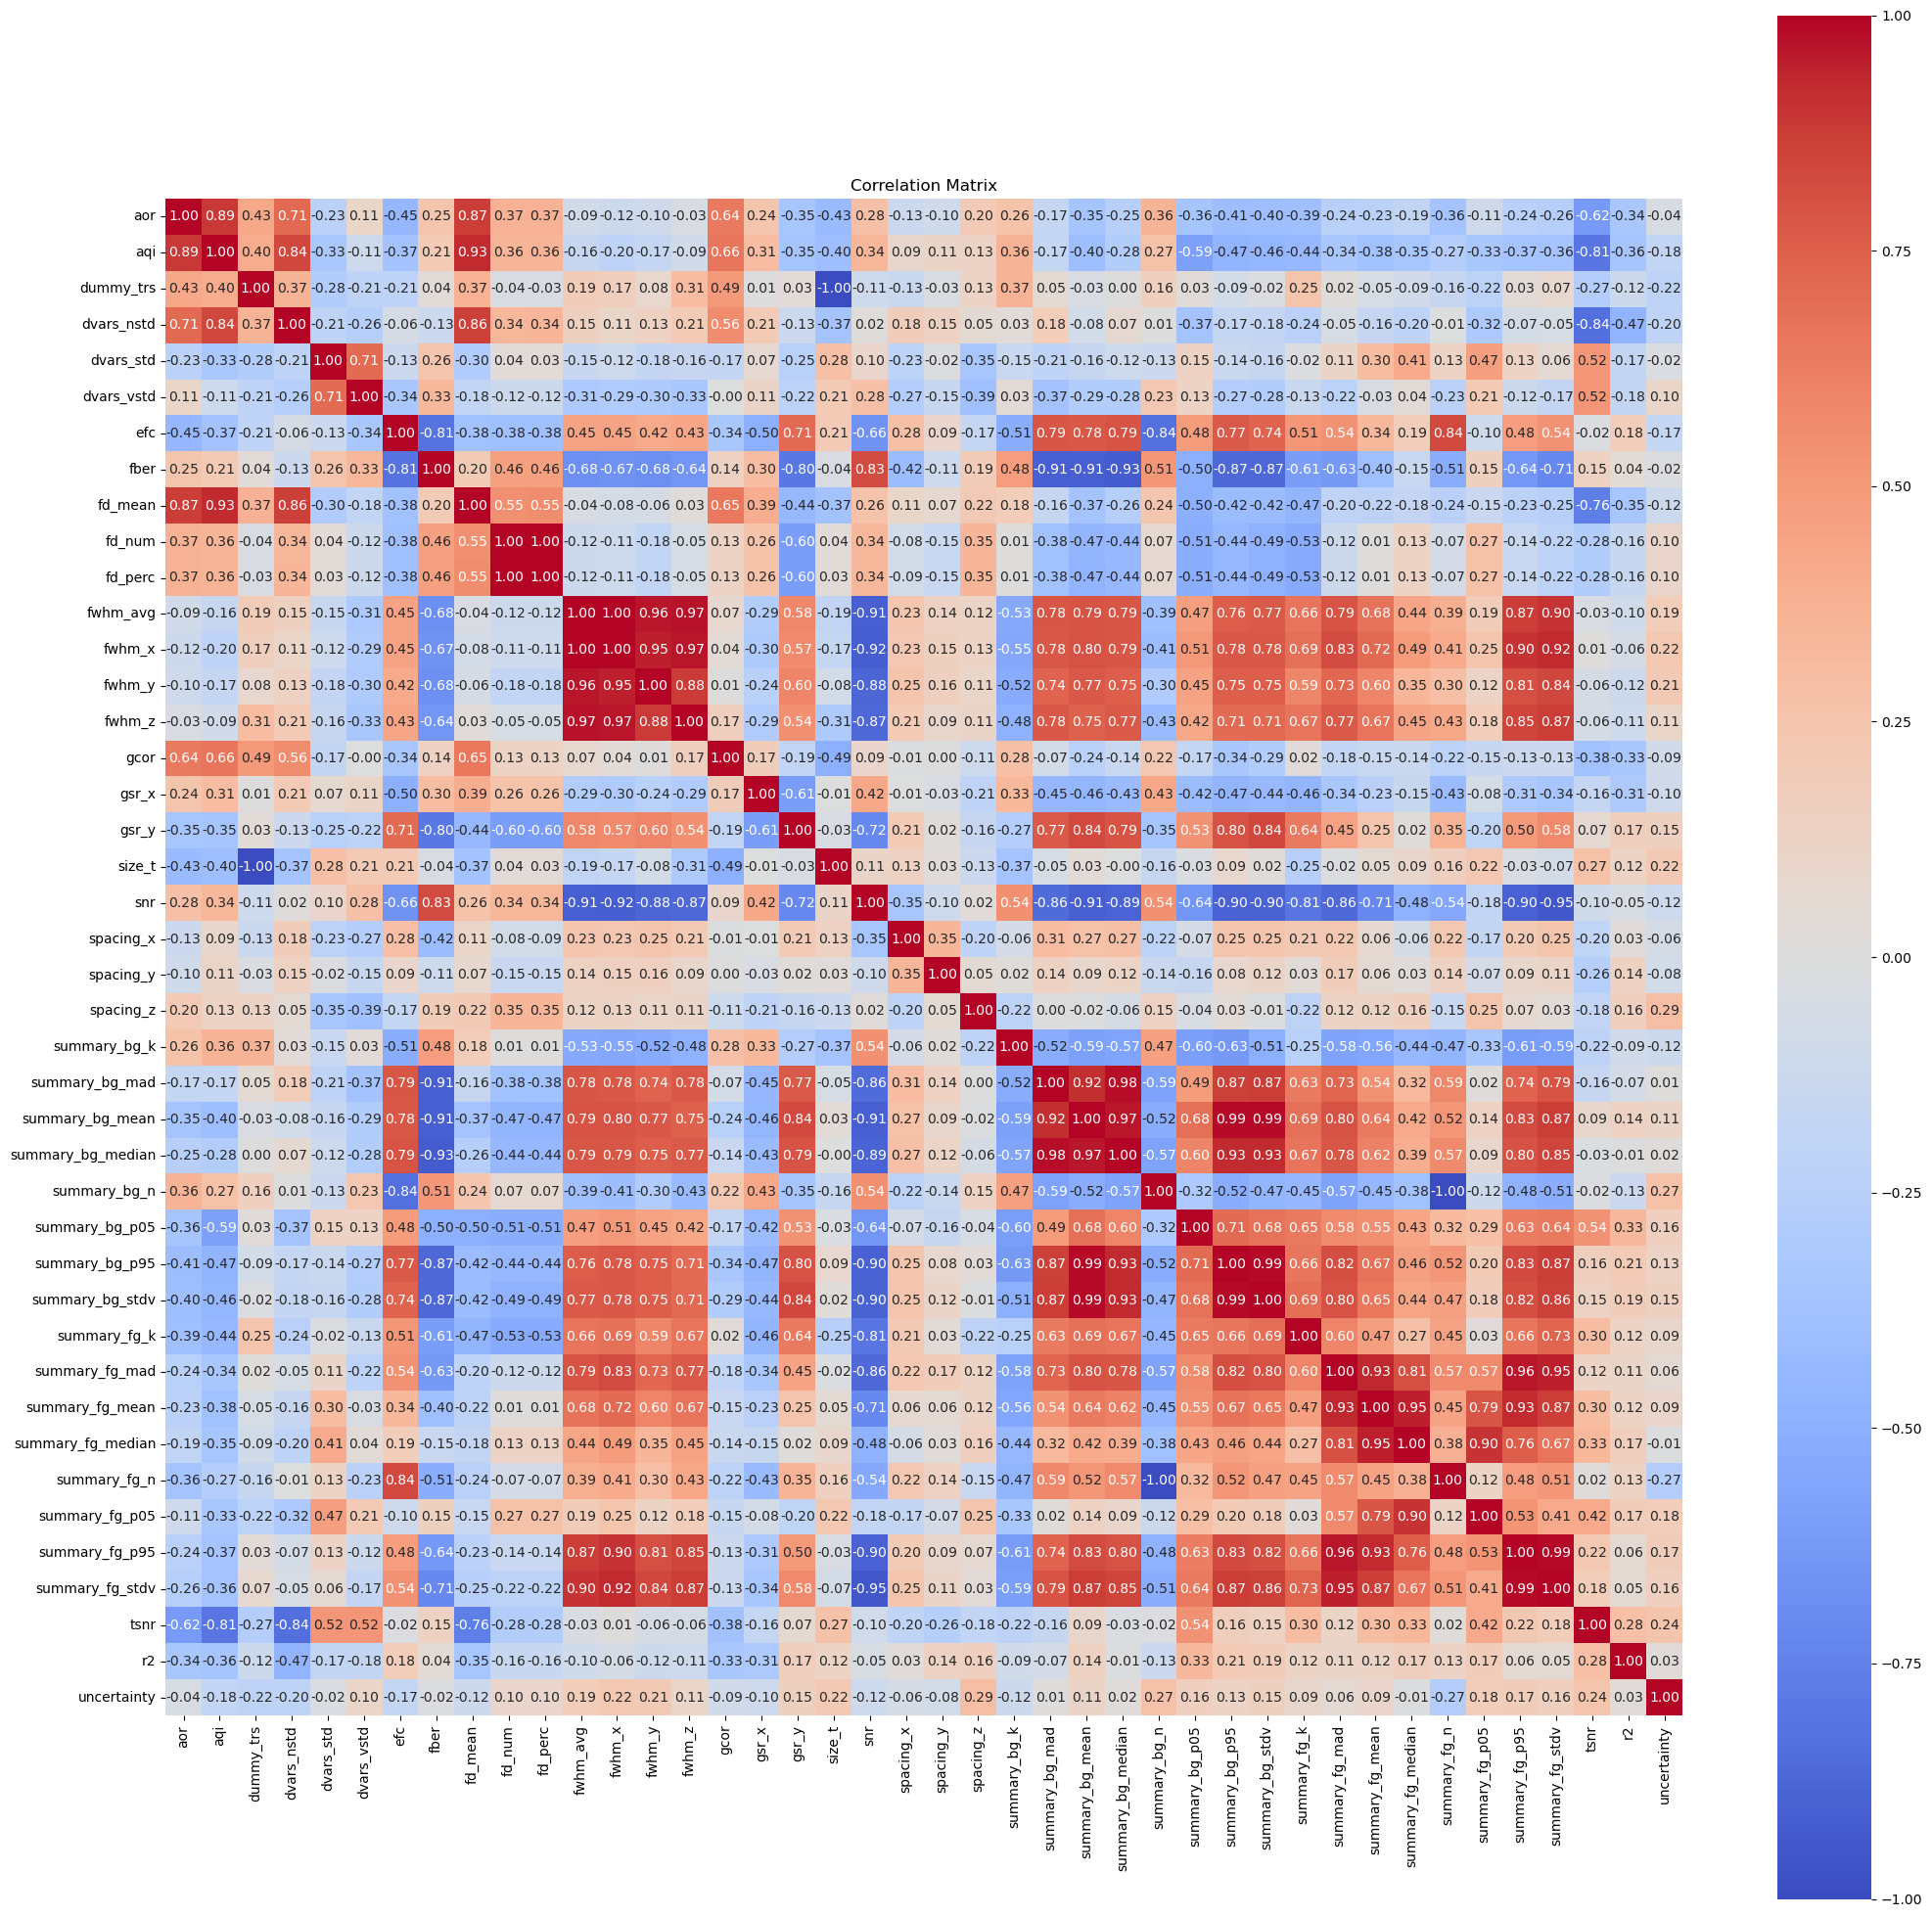

In [31]:
# Assuming 'correlation_matrix' is your correlation matrix
plt.figure(figsize=(25, 25))  # You can adjust the size of the figure as needed
sns.heatmap(features_numeric.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.title('Correlation Matrix')
plt.show()

<Figure size 2500x2500 with 0 Axes>

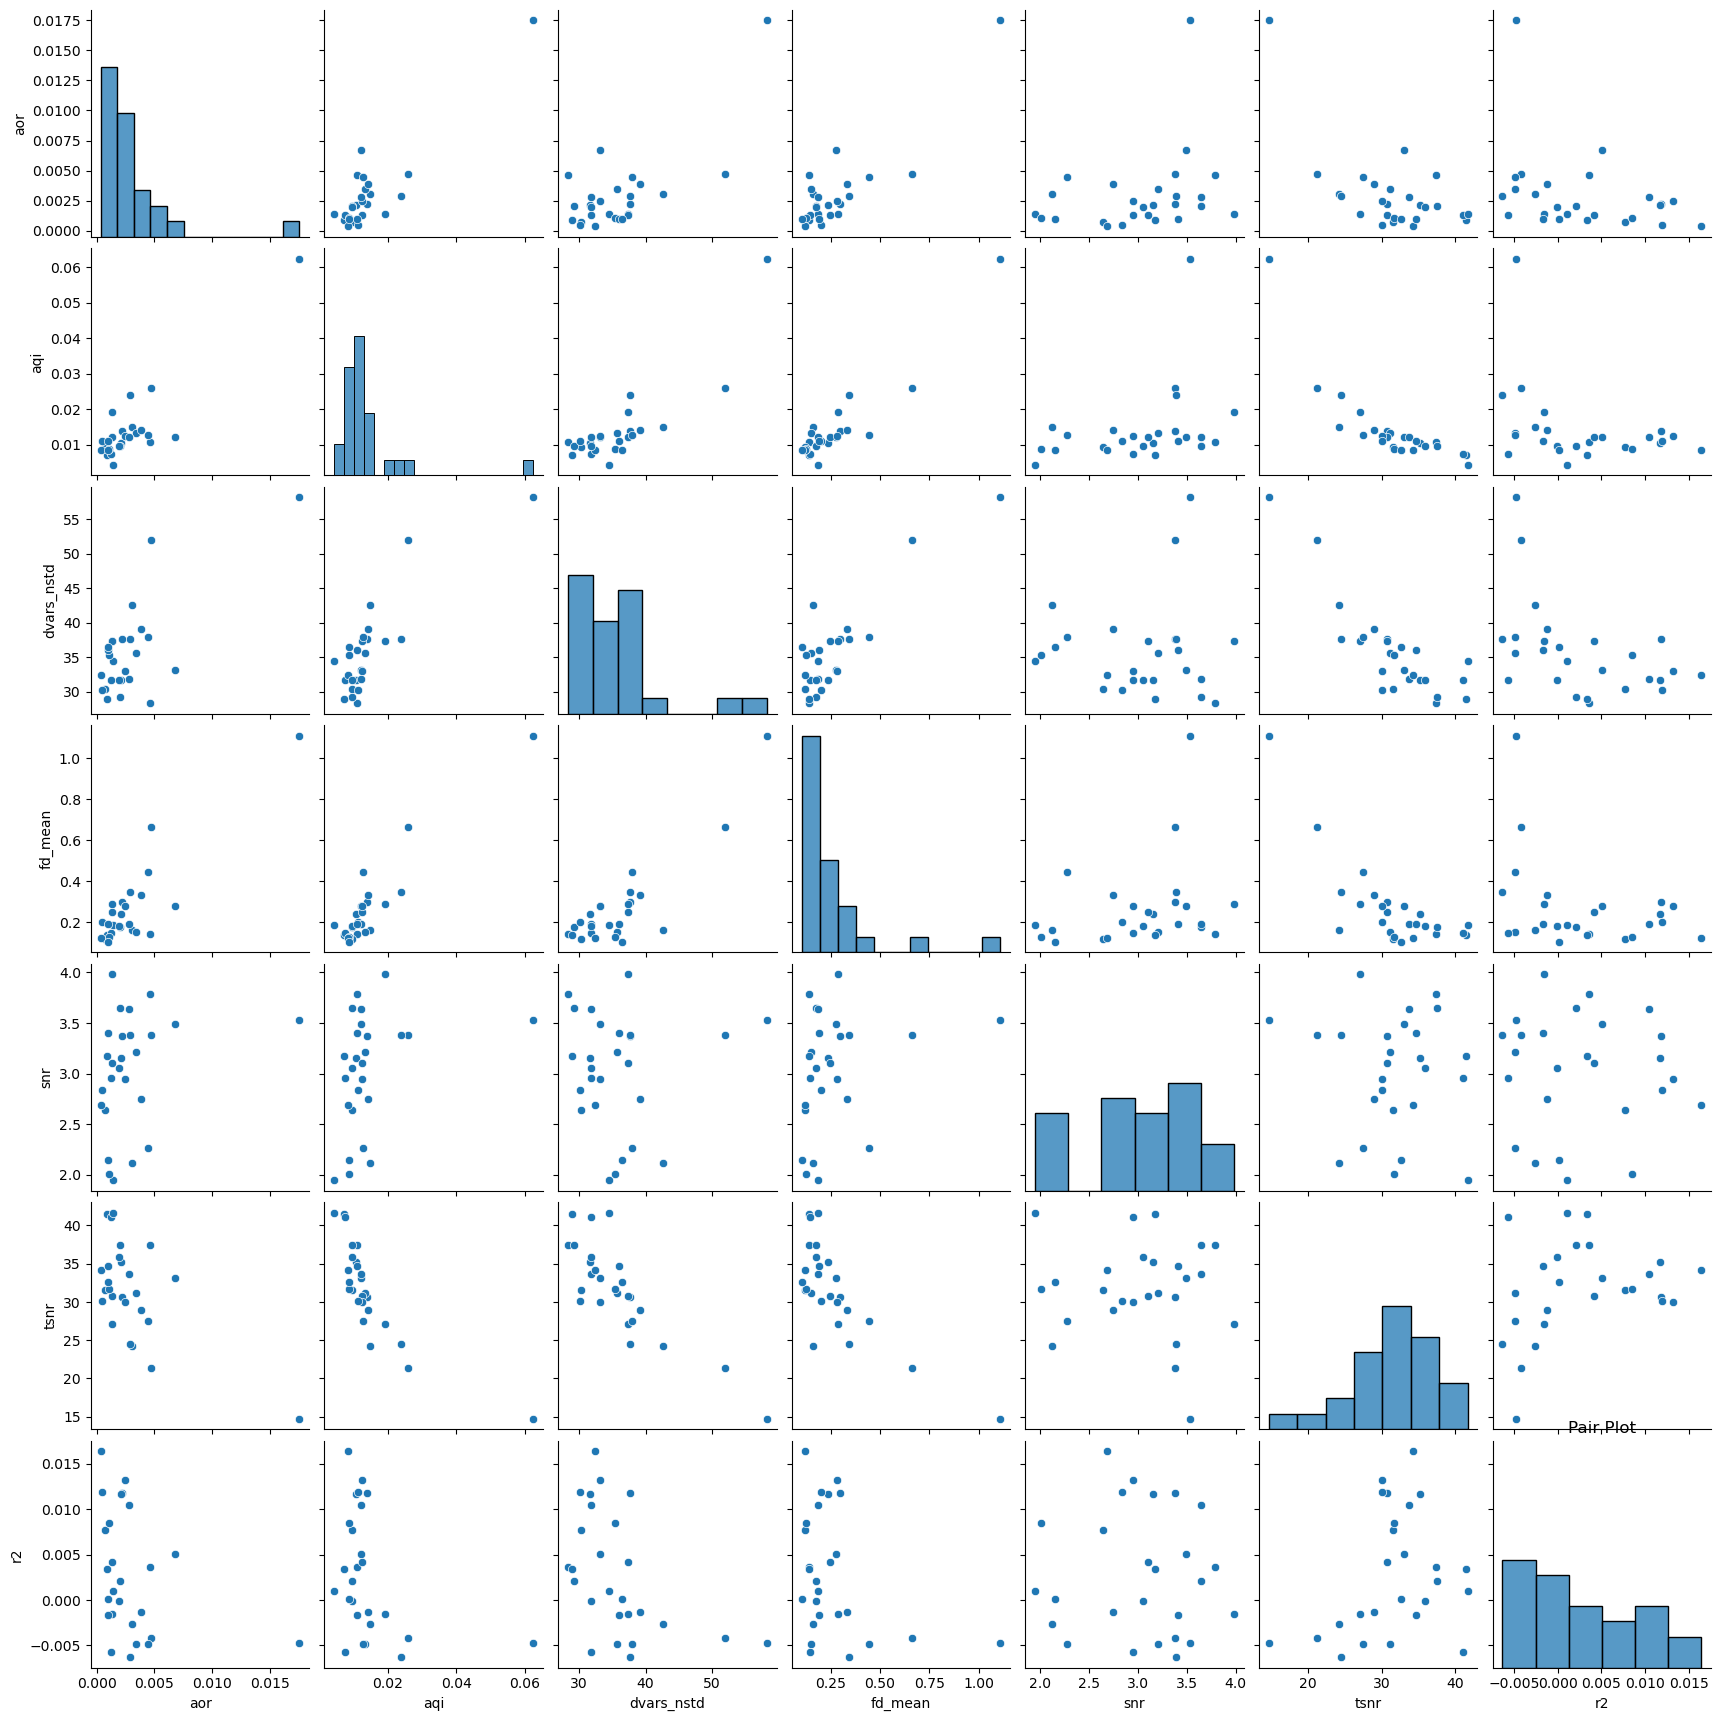

In [22]:
features_df = all_qc_ru_dm[all_qc_ru_dm['sub'].isin(sub_list)]


features=['sub','aor', 'aqi', 'dummy_trs', 'dvars_nstd', 'dvars_std',
       'dvars_vstd', 'efc', 'fber', 'fd_mean', 'fd_num', 'fd_perc', 'fwhm_avg',
       'fwhm_x', 'fwhm_y', 'fwhm_z', 'gcor', 'gsr_x', 'gsr_y', 
       'size_t', 'snr', 
       'spacing_x', 'spacing_y', 'spacing_z', 'summary_bg_k', 'summary_bg_mad',
       'summary_bg_mean', 'summary_bg_median', 'summary_bg_n',
       'summary_bg_p05', 'summary_bg_p95', 'summary_bg_stdv', 'summary_fg_k',
       'summary_fg_mad', 'summary_fg_mean', 'summary_fg_median',
       'summary_fg_n', 'summary_fg_p05', 'summary_fg_p95', 'summary_fg_stdv',
       'tsnr']
features=['sub','aor', 'aqi', 'dvars_nstd', 'fd_mean', 'snr', 
       'tsnr']
features_df=features_df[features]



value_dict = dict(zip(sub_list, mean_stackedr2_list))

# Then you can create a new column in df where the values are mapped according to the 'subject' column
features_df['r2'] = features_df['sub'].map(value_dict)



# features_df['r2'] = mean_stackedr2_list

features_numeric=features_df.drop('sub', axis=1)


# Assuming 'correlation_matrix' is your correlation matrix
plt.figure(figsize=(25, 25))  # You can adjust the size of the figure as needed
sns.pairplot(features_numeric)

plt.title('Pair Plot')
plt.show()